# CNN–LSTM model



## MSFT data

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [ ]:
ticker = 'MSFT'
start_date = '2000-01-01'  # start date
end_date = '2023-12-31'  # end date

data = yf.download(ticker, start=start_date, end=end_date)


/tmp/ipython-input-3876374356.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [ ]:
df_of_interest = data['Close']
df_of_interest.head()

Ticker,MSFT
Date,
2000-01-03,35.601460
2000-01-04,34.398838
2000-01-05,34.761532
2000-01-06,33.597076
2000-01-07,34.036129


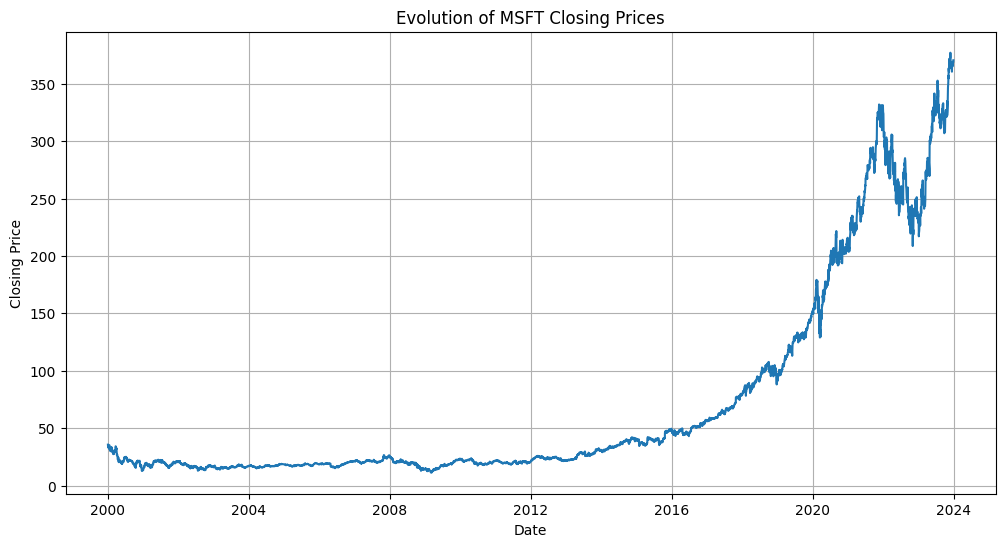

In [ ]:
##Plot of the data

plt.figure(figsize=(12, 6))
plt.plot(df_of_interest.index, df_of_interest.values)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title(f'Evolution of {ticker} Closing Prices')
plt.grid(True)
plt.show()

## We need now to preprocess our data

In [ ]:
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

!pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, num_filters, kernel_size, lstm_hidden_dim, output_dim, num_lstm_layers=1, dropout=0.1):
        super(CNNLSTM, self).__init__()

        # Conv Layer 1D
        self.cnn1 = nn.Conv1d(in_channels=input_dim,
                             out_channels=num_filters,
                             kernel_size=kernel_size,
                             stride=1,
                             padding=kernel_size // 2)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Conv Layer 2D (added second convolutional layer)
        self.cnn2 = nn.Conv1d(in_channels=num_filters,
                             out_channels=num_filters * 2,  # Increased number of filters
                             kernel_size=kernel_size,
                             stride=1,
                             padding=kernel_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)


        # LSTM
        self.lstm = nn.LSTM(input_size=num_filters * 2,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            batch_first=True)

        self.fc1 = nn.Linear(lstm_hidden_dim,1)

    def forward(self, x):


        x = x.permute(0, 2, 1)

        # Convolution
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.dropout(x)


        # Pass through the second convolutional layer
        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool(x)

        x = self.dropout2(x)

        x = x.permute(0, 2, 1)
        # LSTM
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]

        # Pass through the dense layers
        output = self.fc1(last_output)

        return output

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
input_dim = 1
num_filters = 32
kernel_size = 29
lstm_hidden_dim = 100
output_dim = 1
print(f"Using {device} device")

cnnlstm = CNNLSTM(input_dim, num_filters, kernel_size, lstm_hidden_dim, output_dim)
cnnlstm.to(device)

Using cuda device


CNNLSTM(
  (cnn1): Conv1d(1, 32, kernel_size=(29,), stride=(1,), padding=(14,))
  (relu1): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (cnn2): Conv1d(32, 64, kernel_size=(29,), stride=(1,), padding=(14,))
  (relu2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

## Prediction with Log-returns

In [ ]:
##Download the MSFT data from yahoo finance
data = yf.download('MSFT', start='2010-01-01', end='2023-12-31')
data = data[['Close']]

/tmp/ipython-input-741134473.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('MSFT', start='2010-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


In [ ]:
## Normalized the data with minmax scaler

values = data.values

train_end = int(len(values)*0.8)

scaler = MinMaxScaler()
scaler.fit(values[:train_end])      # fit only on TRAIN
scaled_data = scaler.transform(values)  # transform on full series



In [ ]:
##Data processing

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

In [ ]:
import torch
SEQ_LENGTH = 60  # 60 day
sequences, targets = create_sequences(scaled_data, SEQ_LENGTH)

# Data splitting
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]


# Convert to tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).squeeze(1)
X_train= X_train.permute(0, 2, 1)

X_test = torch.tensor(X_test, dtype=torch.float32).squeeze(1)
X_test = X_test.permute(0, 2, 1)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)

torch.Size([2769, 1, 60])
torch.Size([2769, 1])


In [ ]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(CNNLSTMModel, self).__init__()
        # two conv layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        # LSTM layer

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=1, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        # Conv Layer 1
        x = F.relu(self.conv1(x))

        #Conv layer 2
        x = F.relu(self.conv2(x))

        x = self.maxpool(x)

        x = self.dropout(x)

        x = x.permute(0, 2, 1)     # [batch_size, sequence_length, features]

        out, _ = self.lstm(x)

        out = self.fc(out[:, -1, :])  # [batch_size, 1]
        return out



In [ ]:
# modeling
model = CNNLSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch.nn.functional as F

# training
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0460
Epoch [20/50], Loss: 0.0210
Epoch [30/50], Loss: 0.0028
Epoch [40/50], Loss: 0.0026
Epoch [50/50], Loss: 0.0015


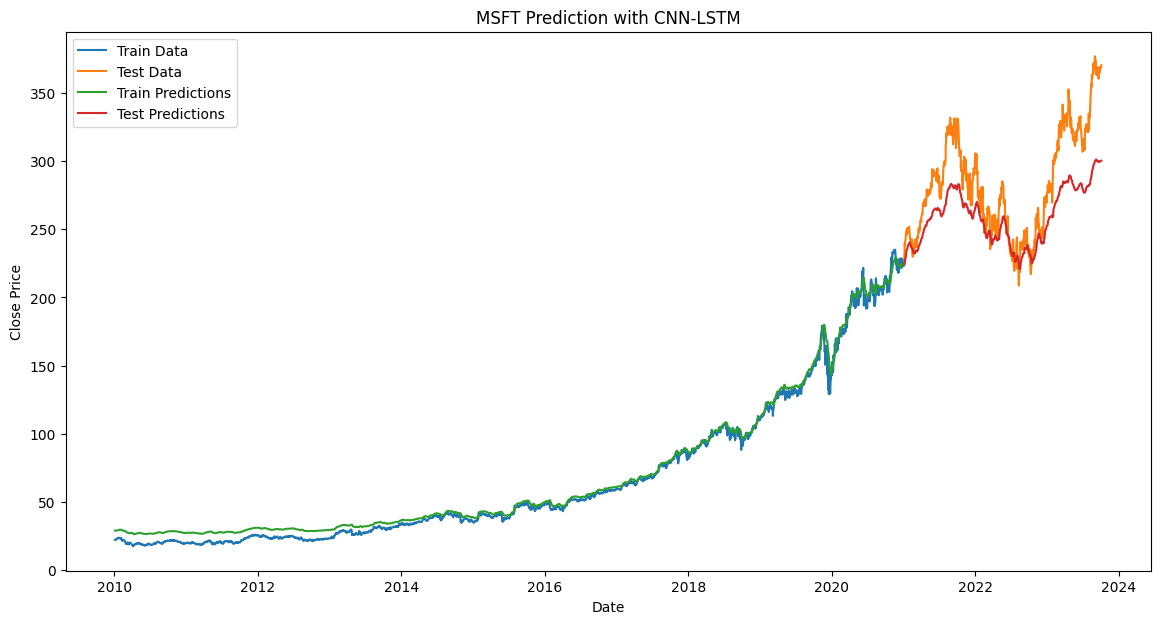

In [ ]:
# 5. Visualazation
model.eval()
with torch.no_grad():
  train_predictions = model(X_train).detach().numpy()
  test_predictions = model(X_test).detach().numpy()

# Inverse scaling (back to price)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

train_pred_inv = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_pred_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))




# viz
plt.figure(figsize=(14, 7))
plt.plot(data.index[:train_size], y_train_inv, label='Train Data')
plt.plot(data.index[train_size:train_size+len(y_test_inv)], y_test_inv, label='Test Data')
plt.plot(data.index[:train_size], train_pred_inv, label='Train Predictions')
plt.plot(data.index[train_size:train_size+len(test_pred_inv)], test_pred_inv, label='Test Predictions')
plt.legend()
plt.title('MSFT Prediction with CNN-LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


In [ ]:


# MSE
mse = mean_squared_error(y_test_inv, test_pred_inv)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_test_inv, test_pred_inv)

print(f"Test MSE  : {mse:.2f}")
print(f"Test RMSE : {rmse:.2f}")
print(f"Test MAE  : {mae:.2f}")


Test MSE  : 945.06
Test RMSE : 30.74
Test MAE  : 24.81


## Prediction with Log-returns

In [ ]:
##Download the MSFT data from yahoo finance
data = yf.download('MSFT', start='2010-01-01', end='2023-12-31')
data['log_price'] = np.log(data['Close'])
data['log_return'] = data['log_price'].diff()
data = data.dropna()


/tmp/ipython-input-1949011237.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('MSFT', start='2010-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


In [ ]:
## Normalized the data with minmax scaler

values = data[['log_return']].values

train_end = int(len(values)*0.8)

scaler = MinMaxScaler()
scaler.fit(values[:train_end])      # fit only on TRAIN
scaled_data = scaler.transform(values)  # transform on full series



In [ ]:
##Data processing

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

In [ ]:
import torch
SEQ_LENGTH = 60  # 60 day
sequences, targets = create_sequences(scaled_data, SEQ_LENGTH)

# Data splitting
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]


# Convert to tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).squeeze(1)
X_train= X_train.permute(0, 2, 1)

X_test = torch.tensor(X_test, dtype=torch.float32).squeeze(1)
X_test = X_test.permute(0, 2, 1)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)

torch.Size([2768, 1, 60])
torch.Size([2768, 1])


In [ ]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(CNNLSTMModel, self).__init__()
        # two conv layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        # LSTM layer

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=1, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        # Conv Layer 1
        x = F.relu(self.conv1(x))

        #Conv layer 2
        x = F.relu(self.conv2(x))

        x = self.maxpool(x)

        x = self.dropout(x)

        x = x.permute(0, 2, 1)     # [batch_size, sequence_length, features]

        out, _ = self.lstm(x)

        out = self.fc(out[:, -1, :])  # [batch_size, 1]
        return out



In [ ]:
# modeling
model = CNNLSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch.nn.functional as F

# training
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0302
Epoch [20/50], Loss: 0.0099
Epoch [30/50], Loss: 0.0099
Epoch [40/50], Loss: 0.0042
Epoch [50/50], Loss: 0.0041


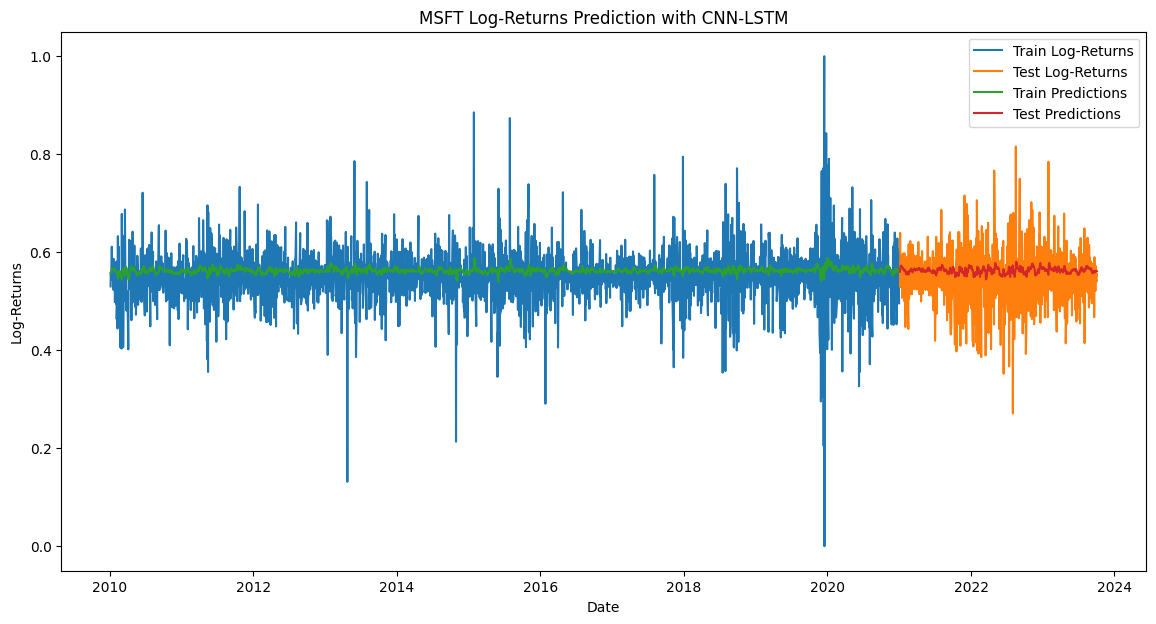

In [ ]:
# 5. Visualazation
model.eval()
with torch.no_grad():
  train_predictions = model(X_train).detach().numpy()
  test_predictions = model(X_test).detach().numpy()



plt.figure(figsize=(14, 7))
plt.plot(data.index[:train_size], y_train.numpy(), label='Train Log-Returns')
plt.plot(data.index[train_size:train_size+len(y_test)], y_test.numpy(), label='Test Log-Returns')
plt.plot(data.index[:train_size], train_predictions, label='Train Predictions')
plt.plot(data.index[train_size:train_size+len(test_predictions)], test_predictions, label='Test Predictions')
plt.legend()
plt.title('MSFT Log-Returns Prediction with CNN-LSTM')
plt.xlabel('Date')
plt.ylabel('Log-Returns')
plt.show()


In [ ]:

#train
train_mse = mean_squared_error(y_train.numpy(), train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train.numpy(), train_predictions)

#test
mse = mean_squared_error(y_test.numpy(), test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test.numpy(), test_predictions)

print("TRAIN:")
print(f"  MSE  : {train_mse:.6f}")
print(f"  RMSE : {train_rmse:.6f}")
print(f"  MAE  : {train_mae:.6f}")
print("TEST:")
print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")


TRAIN:
  MSE  : 0.003294
  RMSE : 0.057392
  MAE  : 0.040176
TEST:
Test MSE  : 0.0040
Test RMSE : 0.0629
Test MAE  : 0.0477
